<a href="https://colab.research.google.com/github/rishiiiiitaaaaa/Nucleus_training_assignments/blob/main/machine_learning/assignment01/C1_C2/ML_partC1_C2_A_clustering_wine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#A1


In [ ]:
# 1) SETUP & DATA LOAD

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler

# Load sklearn Wine dataset
wine = load_wine()
df = pd.DataFrame(wine.data, columns=wine.feature_names)
df["target"] = wine.target   # add the class labels (0,1,2)

print("Loaded shape:", df.shape)
display(df.head())


Loaded shape: (178, 14)


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


# A2


In [ ]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns:", num_cols)

print("Missing values per column:")
display(df.isnull().sum())

dup_count = df.duplicated().sum()
print(f"Duplicate rows: {dup_count}")

# Quick outlier count using IQR per numeric column
iqr_outlier_counts = {}
for c in num_cols:
    Q1, Q3 = df[c].quantile(0.25), df[c].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    iqr_outlier_counts[c] = ((df[c] < lower) | (df[c] > upper)).sum()

print("Approx outlier counts by feature (IQR rule):")
display(pd.Series(iqr_outlier_counts).sort_values(ascending=False))
# Insights
# Wine data typically has no missing.
# Some duplicates can appear.
# Outliers often in volatile acidity, sulphates, residual sugar.

Numeric columns: ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline', 'target']
Missing values per column:


,0
alcohol,0
malic_acid,0
ash,0
alcalinity_of_ash,0
magnesium,0
total_phenols,0
flavanoids,0
nonflavanoid_phenols,0
proanthocyanins,0
color_intensity,0


Duplicate rows: 0
Approx outlier counts by feature (IQR rule):


,0
magnesium,4
alcalinity_of_ash,4
color_intensity,4
ash,3
malic_acid,3
proanthocyanins,2
hue,1
alcohol,0
total_phenols,0
nonflavanoid_phenols,0


# A3

In [ ]:
df_clean = df.copy()

# 7.1 Remove exact duplicate rows (safe)
before = df_clean.shape[0]
df_clean = df_clean.drop_duplicates()
after = df_clean.shape[0]
print(f"Removed {before - after} duplicate rows.")

# 7.2 Imputation (usually not needed here, but included for completeness)
# Numeric → median; (no categorical in raw features)
imputer = SimpleImputer(strategy='median')
df_clean[num_cols] = imputer.fit_transform(df_clean[num_cols])

# 7.3 Outlier handling via IQR capping (winsorization)
def cap_outliers_iqr(series, factor=1.5):
    Q1, Q3 = series.quantile(0.25), series.quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - factor*IQR, Q3 + factor*IQR
    return series.clip(lower=lower, upper=upper)

for c in num_cols:
    df_clean[c] = cap_outliers_iqr(df_clean[c], factor=1.5)

print("Cleaning done. Shape:", df_clean.shape)
# Insights
# We safely removed duplicates and capped extreme values to reduce undue influence on scaling/regression/clustering.
# Median imputation is robust (even if no NaNs).

Removed 0 duplicate rows.
Cleaning done. Shape: (178, 14)


# A4

In [ ]:
# We already have target in df["target"] (0, 1, 2)

# If you want a human-readable class name column (optional)
target_names = {i: name for i, name in enumerate(wine.target_names)}
df['target_name'] = df['target'].map(target_names)

# Standardize numeric features (all columns except target)
num_cols = wine.feature_names
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[num_cols] = scaler.fit_transform(df_scaled[num_cols])

print("Scaled numeric columns (first 5 rows):")
display(df_scaled[num_cols].head())

# Insights
# - StandardScaler centers/normalizes features → helps clustering.
# - target (0,1,2) or target_name gives true class labels (for evaluation).


Scaled numeric columns (first 5 rows):


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,1.518613,-0.562250,0.232053,-1.169593,1.913905,0.808997,1.034819,-0.659563,1.224884,0.251717,0.362177,1.847920,1.013009
1,0.246290,-0.499413,-0.827996,-2.490847,0.018145,0.568648,0.733629,-0.820719,-0.544721,-0.293321,0.406051,1.113449,0.965242
2,0.196879,0.021231,1.109334,-0.268738,0.088358,0.808997,1.215533,-0.498407,2.135968,0.269020,0.318304,0.788587,1.395148
3,1.691550,-0.346811,0.487926,-0.809251,0.930918,2.491446,1.466525,-0.981875,1.032155,1.186068,-0.427544,1.184071,2.334574
4,0.295700,0.227694,1.840403,0.451946,1.281985,0.808997,0.663351,0.226796,0.401404,-0.319276,0.362177,0.449601,-0.037874


# A5


In [ ]:
df_feat = df_scaled.copy()

# Ratios / domain-inspired combos
df_feat['alcohol_to_ash'] = df_feat['alcohol'] / (df_feat['ash'] + 1e-6)
df_feat['phenols_to_flavanoids'] = df_feat['total_phenols'] / (df_feat['flavanoids'] + 1e-6)

# Aggregates
df_feat['phenolic_sum'] = df_feat['total_phenols'] + df_feat['flavanoids'] + df_feat['nonflavanoid_phenols']

print("New feature samples:")
display(df_feat[['alcohol_to_ash','phenols_to_flavanoids','phenolic_sum']].head())

# Insights
# - alcohol_to_ash: normalizes alcohol strength against ash content.
# - phenols_to_flavanoids: balances general vs specific phenolic compounds.
# - phenolic_sum: a composite feature reflecting overall phenolic richness.


New feature samples:


,alcohol_to_ash,phenols_to_flavanoids,phenolic_sum
0,6.544233,0.781776,1.184253
1,-0.297453,0.775115,0.481557
2,0.177475,0.665549,1.526123
3,3.466806,1.698876,2.976095
4,0.160671,1.219559,1.699144


# A6

In [ ]:
from sklearn.feature_selection import chi2, SelectKBest, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

X = pd.DataFrame(wine.data, columns=wine.feature_names)
y = wine.target

# 1. Filter Method - Chi-square

chi2_selector = SelectKBest(score_func=chi2, k=8)  # top 8 features
X_chi2 = chi2_selector.fit_transform(X, y)
chi2_features = X.columns[chi2_selector.get_support()]
print("Top Chi-square selected features:")
print(chi2_features)

# 2. Embedded Method - RandomForest Feature Importance
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X, y)

importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nRandomForest Feature Importances:")
print(importances.head(8))


Top Chi-square selected features:
Index(['malic_acid', 'alcalinity_of_ash', 'magnesium', 'total_phenols',
       'flavanoids', 'color_intensity', 'od280/od315_of_diluted_wines',
       'proline'],
      dtype='object')

RandomForest Feature Importances:
flavanoids                      0.183580
proline                         0.172865
color_intensity                 0.164199
alcohol                         0.123381
od280/od315_of_diluted_wines    0.102783
hue                             0.077608
total_phenols                   0.045954
malic_acid                      0.028601
dtype: float64


#C1: Clustering

In [ ]:
# imports
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score
from scipy.cluster.hierarchy import dendrogram, linkage
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# 2. Load Wine Dataset
wine = load_wine()
X = pd.DataFrame(wine.data, columns=wine.feature_names)
y_true = wine.target   # true wine class labels (0,1,2)

In [ ]:
# 3. Scale Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# 4. K-Means Clustering
inertia = []
silhouette = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_scaled, labels))


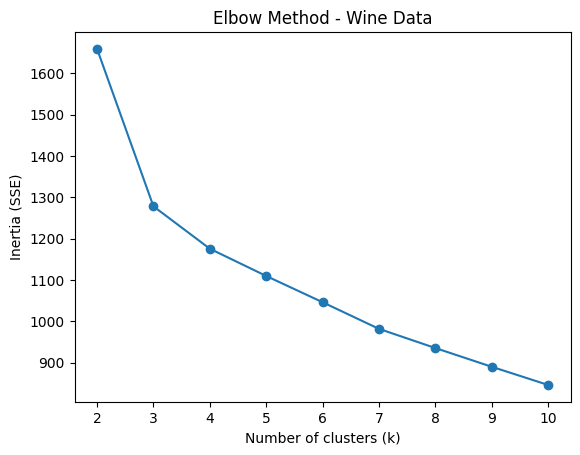

In [ ]:

# Plot Elbow Method
plt.plot(K, inertia, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (SSE)")
plt.title("Elbow Method - Wine Data")
plt.show()



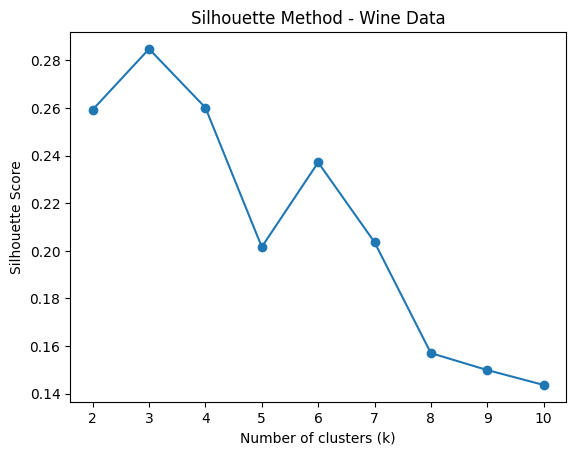

In [ ]:
# Plot Silhouette Scores
plt.plot(K, silhouette, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Method - Wine Data")
plt.show()



In [ ]:
# Choose best k (from silhouette)
best_k = K[np.argmax(silhouette)]
print("Optimal k (silhouette):", best_k)

# Final KMeans
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

print("KMeans ARI:", adjusted_rand_score(y_true, kmeans_labels))



Optimal k (silhouette): 3
KMeans ARI: 0.8974949815093207


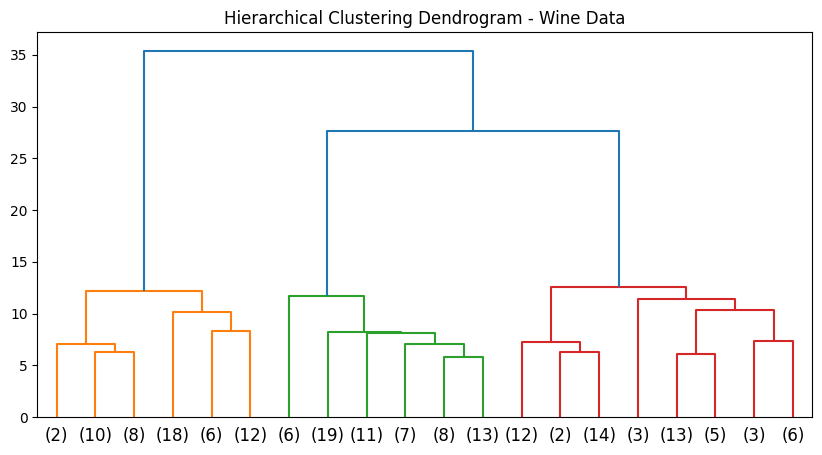

Hierarchical ARI: 0.7899332213582837


In [ ]:
# 5. Hierarchical Clustering
Z = linkage(X_scaled, method="ward")

plt.figure(figsize=(10, 5))
dendrogram(Z, truncate_mode="lastp", p=20)
plt.title("Hierarchical Clustering Dendrogram - Wine Data")
plt.show()

agg = AgglomerativeClustering(n_clusters=best_k, linkage="ward")
agg_labels = agg.fit_predict(X_scaled)

print("Hierarchical ARI:", adjusted_rand_score(y_true, agg_labels))




# C2. Dimensionality Reduction

Explained variance ratio (2D PCA): [0.36198848 0.1920749 ]
Total variance retained (2D PCA): 0.5540633835693526


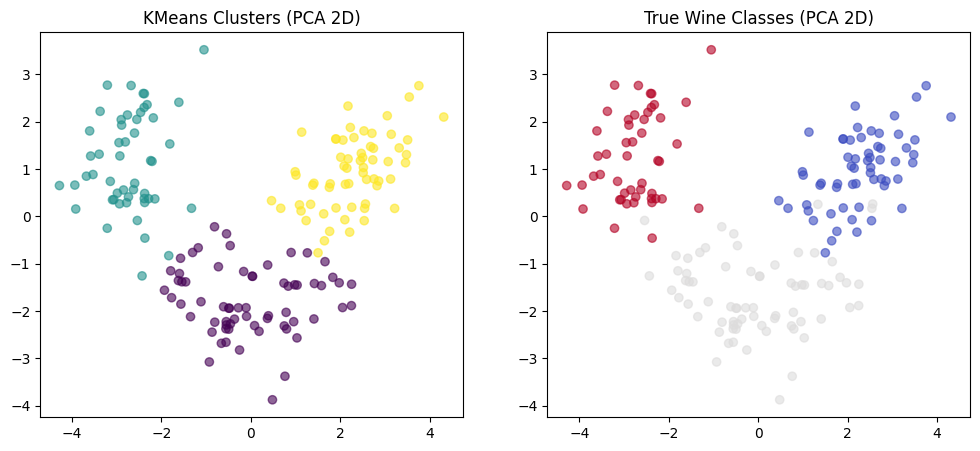

In [ ]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# PCA 2D
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

print("Explained variance ratio (2D PCA):", pca_2d.explained_variance_ratio_)
print("Total variance retained (2D PCA):", np.sum(pca_2d.explained_variance_ratio_))

plt.figure(figsize=(12,5))

# KMeans Clusters (2D PCA)
plt.subplot(1,2,1)
plt.scatter(X_pca_2d[:,0], X_pca_2d[:,1], c=kmeans_labels, cmap="viridis", alpha=0.6)
plt.title("KMeans Clusters (PCA 2D)")

# True Labels (2D PCA)
plt.subplot(1,2,2)
plt.scatter(X_pca_2d[:,0], X_pca_2d[:,1], c=y_true, cmap="coolwarm", alpha=0.6)
plt.title("True Wine Classes (PCA 2D)")

plt.show()



Explained variance ratio (3D PCA): [0.36198848 0.1920749  0.11123631]
Total variance retained (3D PCA): 0.6652996889318523


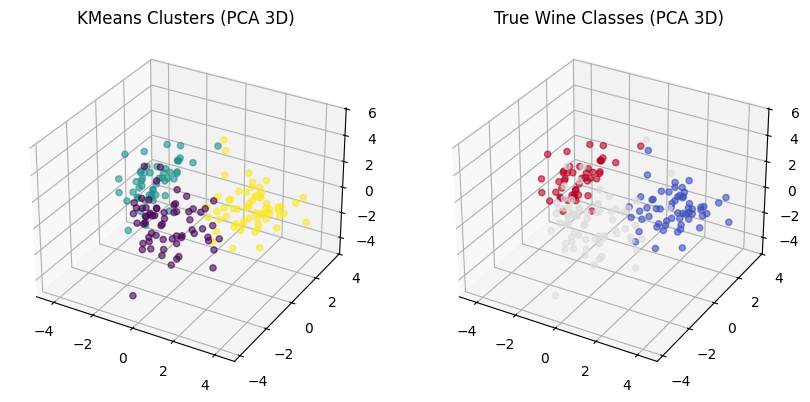

In [ ]:

# PCA 3D
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)

print("Explained variance ratio (3D PCA):", pca_3d.explained_variance_ratio_)
print("Total variance retained (3D PCA):", np.sum(pca_3d.explained_variance_ratio_))

fig = plt.figure(figsize=(10,7))

# 3D Scatter with KMeans labels
ax = fig.add_subplot(121, projection='3d')
ax.scatter(X_pca_3d[:,0], X_pca_3d[:,1], X_pca_3d[:,2], c=kmeans_labels, cmap="viridis", alpha=0.6)
ax.set_title("KMeans Clusters (PCA 3D)")

# 3D Scatter with True labels
ax = fig.add_subplot(122, projection='3d')
ax.scatter(X_pca_3d[:,0], X_pca_3d[:,1], X_pca_3d[:,2], c=y_true, cmap="coolwarm", alpha=0.6)
ax.set_title("True Wine Classes (PCA 3D)")

plt.show()


In [ ]:
#Explanation of variance retained
print("\nInterpretation:")
print(f"Using 2 PCA components, we retain {np.sum(pca_2d.explained_variance_ratio_):.2%} of the variance.")
print(f"Using 3 PCA components, we retain {np.sum(pca_3d.explained_variance_ratio_):.2%} of the variance.")
print("This shows PCA reduces dimensionality while preserving most of the information.")


Interpretation:
Using 2 PCA components, we retain 55.41% of the variance.
Using 3 PCA components, we retain 66.53% of the variance.
This shows PCA reduces dimensionality while preserving most of the information.
